# Electricity Demand Forecasting

## Model Evaluation

For the final model evaluation we choose the best prophet model and evaluate
the model with out of sample data.  Because some of the exogeneous data is
weather related and we would not know the exact weather prior to the day we
will add some random variation to the data before using it for input to the
prediction portion of the model.

## <table id='Table_Of_Contents'>Table Of Contents</table>

1. [Import Modules](#import)<br>
2. [Read Data File](#read_data)<br>
    1. [Clean Data Frame](#clean_data)<br>
    2. [Data Split](#data_split)<br>




In [43]:
import os
import sys

import numpy as np
import pandas as pd

import re

import json
import datetime


from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

import pickle
import warnings

from dateutil import parser
import dateutil

from fbprophet import Prophet

import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.statespace.mlemodel

In [44]:
# Read in the training and test data sets
X_train = pd.read_csv('../data/big_demand_temp_train.csv', index_col=0)
X_val = pd.read_csv('../data/big_demand_temp_validation.csv', index_col=0)

X_train.index = pd.DatetimeIndex(X_train.index)
X_val.index = pd.DatetimeIndex(X_val.index)

In [45]:
X_train.tail()

,demand,Los Angeles,San Diego,San Jose,San Francisco,Sacramento,Fresno,CA_pop,Mon,Tue,Wed,Thur,Fri,Sat,Sun,DOW
2019-03-31 19:00:00+00:00,21782,78.14,76.39,66.93,60.40,61.51,63.82,14173349.0,0,0,0,0,0,0,1,6
2019-03-31 20:00:00+00:00,21851,81.11,79.76,69.05,62.56,64.24,67.47,14173349.0,0,0,0,0,0,0,1,6
2019-03-31 21:00:00+00:00,21960,81.93,78.97,72.43,66.71,67.20,70.13,14173349.0,0,0,0,0,0,0,1,6
2019-03-31 22:00:00+00:00,22742,82.54,77.68,74.24,67.60,70.43,72.52,14173349.0,0,0,0,0,0,0,1,6
2019-03-31 23:00:00+00:00,23027,82.41,76.83,74.12,68.53,72.14,74.41,14173349.0,0,0,0,0,0,0,1,6


In [46]:
X_val.head()

,demand,Los Angeles,San Diego,San Jose,San Francisco,Sacramento,Fresno,CA_pop,Mon,Tue,Wed,Thur,Fri,Sat,Sun,DOW
2019-04-01 00:00:00+00:00,24233,81.03,76.26,73.87,65.30,73.42,75.23,14173349.0,1,0,0,0,0,0,0,0
2019-04-01 01:00:00+00:00,25377,77.71,73.92,71.25,62.63,73.58,74.98,14173349.0,1,0,0,0,0,0,0,0
2019-04-01 02:00:00+00:00,25263,74.85,71.90,68.08,60.05,73.29,73.82,14173349.0,1,0,0,0,0,0,0,0
2019-04-01 03:00:00+00:00,26855,71.74,70.20,64.87,58.02,64.46,71.32,14173349.0,1,0,0,0,0,0,0,0
2019-04-01 04:00:00+00:00,26907,70.26,69.32,61.56,57.41,67.34,67.98,14173349.0,1,0,0,0,0,0,0,0


Align the data frame to the start of a week

In [47]:
def agg_weekly(data_frame) :
    # Aggregate data on a weekly basis
    current_day = data_frame.index[0].date()
    row = data_frame.index[0]
    current_dow = data_frame.loc[row, 'DOW']
    week_demand = 0.0
    X_by_week = pd.DataFrame([], index=[current_day], \
        columns=['week_demand', 'CA_pop', 'la_high', 'sd_high', 'sj_high', 'sf_high',\
                 'sac_high', 'f_high', 'DOW' ])

    la_high = 0
    sd_high = 0
    f_high = 0
    sj_high = 0
    sf_high = 0
    sac_high = 0
    pop=0
    found_tue = False

    print(current_dow)
    for row in data_frame.index :
        next_dow = data_frame.loc[row].DOW
        if next_dow == 0 and found_tue == False :
            current_day = row.date()

        if next_dow == 1 :
            found_tue = 1

        if next_dow == 0 and found_tue :
            X_by_week.loc[current_day] = [week_demand, pop, \
                la_high, sd_high, sj_high, sf_high, sac_high, f_high, current_day.weekday()]
            '''
            {'day_demand' :day_demand, 'la_high': la_high,\
                'sd_high' : sd_high, 'f_high' : f_high, 'DOW' : current_day.weekday()}
            '''
            current_dow = next_dow
            found_tue = False
            la_high = 0
            sd_high = 0
            f_high = 0
            sj_high = 0
            sf_high = 0
            sac_high = 0
            pop=0
            week_demand = 0
        else :
            week_demand += data_frame.loc[row, 'demand']
            pop = data_frame.loc[row, 'CA_pop']
            if data_frame.loc[row, 'Los Angeles'] > la_high :
                la_high = data_frame.loc[row, 'Los Angeles']
            if data_frame.loc[row, 'San Diego'] > sd_high :
                sd_high = data_frame.loc[row, 'San Diego']
            if data_frame.loc[row, 'Fresno'] > f_high :
                f_high = data_frame.loc[row, 'Fresno']
            if data_frame.loc[row, 'San Francisco'] > sf_high :
                sf_high = data_frame.loc[row, 'San Francisco']
            if data_frame.loc[row, 'San Jose'] > sj_high :
                sj_high = data_frame.loc[row, 'San Jose']
            if data_frame.loc[row, 'Sacramento'] > sac_high :
                sac_high = data_frame.loc[row, 'Sacramento']
                
    X_by_week.loc[current_day] = [week_demand, pop, \
        la_high, sd_high, sj_high, sf_high, sac_high, f_high, current_day.weekday()]

                
    return X_by_week

In [48]:
# Aggregate data on a daily basis
def agg_daily(data_frame):
    current_day = data_frame.index[0].date()
    day_demand = 0.0
    X_by_day = pd.DataFrame([], index=[current_day], \
        columns=['day_demand', 'CA_pop', 'la_high', 'sd_high', 'sj_high', 'sf_high',\
                 'sac_high', 'f_high', 'DOW' ])
    la_high = 0
    sd_high = 0
    f_high = 0
    sj_high = 0
    sf_high = 0
    sac_high = 0
    pop = 0

    for row in data_frame.index :
        next_day = row.date()
        if next_day != current_day :
            X_by_day.loc[current_day] = [day_demand, pop, la_high, sd_high, sj_high, sf_high, \
                        sac_high, f_high, current_day.weekday()]
            '''
            {'day_demand' :day_demand, 'la_high': la_high,\
                'sd_high' : sd_high, 'f_high' : f_high, 'DOW' : current_day.weekday()}
            '''
            current_day = next_day
            la_high = 0
            sd_high = 0
            sj_high = 0
            sf_high = 0
            sac_high = 0
            f_high = 0
            day_demand = 0
            pop=0
        else :
            day_demand += data_frame.loc[row, 'demand']
            pop = data_frame.loc[row, 'CA_pop']
            if data_frame.loc[row, 'Los Angeles'] > la_high :
                la_high = data_frame.loc[row, 'Los Angeles']
            if data_frame.loc[row, 'San Diego'] > sd_high :
                sd_high = data_frame.loc[row, 'San Diego']
            if data_frame.loc[row, 'Fresno'] > f_high :
                f_high = data_frame.loc[row, 'Fresno']
            if data_frame.loc[row, 'San Jose'] > sj_high :
                sj_high = data_frame.loc[row, 'San Jose']
            if data_frame.loc[row, 'San Francisco'] > sf_high :
                sf_high = data_frame.loc[row, 'San Francisco']
            if data_frame.loc[row, 'Sacramento'] > sac_high :
                sac_high = data_frame.loc[row, 'Sacramento']
    
    X_by_day.loc[current_day] = [day_demand, pop, la_high, sd_high, sj_high, sf_high, \
                sac_high, f_high, current_day.weekday()]
    
    return X_by_day

    

In [49]:
# drop all the rows before the start of the fisrt Monday
def find_week_start(data) :
    rows_to_drop = []
    for row in data.index :
        if data.loc[row, 'DOW'] != 0:
            rows_to_drop.append(row)
        else:
            break
            
    return rows_to_drop

In [50]:
X_val_daily = agg_daily(X_val)
X_train_daily = agg_daily(X_train)


In [51]:
X_train_daily.tail()

,day_demand,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,DOW
2019-03-27,603317,1.41733e+07,69.71,66.64,67.03,61.34,65.39,72.08,2
2019-03-28,612332,1.41733e+07,67.49,66.66,64.57,61.27,61.21,68.11,3
2019-03-29,609430,1.41733e+07,70.69,66.45,62.49,58.67,61.7,67.93,4
2019-03-30,589672,1.41733e+07,79.99,69.88,66.95,62.73,67.95,69.09,5
2019-03-31,554156,1.41733e+07,82.54,79.76,74.24,68.53,72.14,74.41,6


In [52]:
X_val_daily.head()

,day_demand,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,DOW
2019-04-01,626489,1.41733e+07,81.71,76.26,73.87,65.3,73.58,77.52,0
2019-04-02,639427,1.41733e+07,77.11,68.42,64.76,60.96,62.96,75.71,1
2019-04-03,637476,1.41733e+07,66.84,64.95,62.4,57.87,62.82,70.45,2
2019-04-04,637018,1.41733e+07,66.69,65.34,62.68,60.93,64.1,69.31,3
2019-04-05,610351,1.41733e+07,66.07,64.94,64.02,60.99,63.16,67.1,4


In [53]:
X_train_daily.rename({'day_demand' : 'y'}, axis=1, inplace=True)
X_train_daily['ds'] = X_train_daily.index
X_train_daily.index = pd.DatetimeIndex(X_train_daily.index)
X_train_daily.tail()

,y,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,DOW,ds
2019-03-27,603317,1.41733e+07,69.71,66.64,67.03,61.34,65.39,72.08,2,2019-03-27
2019-03-28,612332,1.41733e+07,67.49,66.66,64.57,61.27,61.21,68.11,3,2019-03-28
2019-03-29,609430,1.41733e+07,70.69,66.45,62.49,58.67,61.7,67.93,4,2019-03-29
2019-03-30,589672,1.41733e+07,79.99,69.88,66.95,62.73,67.95,69.09,5,2019-03-30
2019-03-31,554156,1.41733e+07,82.54,79.76,74.24,68.53,72.14,74.41,6,2019-03-31


In [54]:
X_val_daily.rename({'day_demand' : 'y'}, axis=1, inplace=True)
X_val_daily['ds'] = X_val_daily.index
X_val_daily.index = pd.DatetimeIndex(X_val_daily.index)

In [61]:
elec_df = X_train_daily.append(X_val_daily)

In [56]:
def data_block(X, start, out_size) :
    # get the slices of data frames to provide the blocks requested
    block1 = X.iloc[start:start+out_size, :]
        
    return block1
    

In [57]:
def prophet_walk_forward_val(data, start_size, val_window, regressors, steps) :
    '''
        Function: walk_forward_val
        
        Arguments:
            model - model class instantiator
            data - pandas dataframe containing data of interest
            start_size - initial number of rows for training
            val_window - size of the validation window for each trail
            regressors - list of regressors to add to the model
            steps - number of walk forward steps to run
        
        Return:
            mape_list - list of tupels with the last index for training window and mape for the window
    '''
    mape_list = []
    # for each steps
    for step in range(steps) :
        print(start_size+step*val_window)
        # Get the block of data for training
        train_dat = data_block(data, 0, start_size+step*val_window)
        
        # Get a block of data for validation
        val_dat = data_block(data, start_size+step*val_window, val_window)
        
        # Instantiate the model
        m = Prophet(weekly_seasonality=True, yearly_seasonality=True)
        
        # Add regressors
        for reg in regressors :
            m.add_regressor(reg)
            
        # Fit the model
        m.fit(train_dat)
        
        # Forecast for the validation step
        forecast = m.predict(val_dat)
        forecast.index = val_dat.index
        print(forecast['ds'].values[0], val_dat['ds'].values[0])
        
        # Caluclate the MAPE for the window
        ape = [np.abs(val_dat.loc[x, 'y'] - forecast.loc[x, 'yhat']) / val_dat.loc[x, 'y'] * 100 for x in val_dat.index]
        
        # Add the values to the list
        mape_list.append((train_dat.index[-1], np.mean(ape)))
        
    # return the mape list
    return mape_list

In [62]:
elec_df.head()

,y,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,DOW,ds
2015-07-01,615661,1.38458e+07,85.78,75.72,92.65,69.25,98.16,96.38,2,2015-07-01
2015-07-02,916143,1.38458e+07,85.37,77.99,84.95,66.43,99.17,99.75,3,2015-07-02
2015-07-03,855334,1.38458e+07,82.31,76.39,83.64,68.14,97.25,99.66,4,2015-07-03
2015-07-04,818332,1.38458e+07,79.9,72.2,83.68,66.09,100.92,100.22,5,2015-07-04
2015-07-05,759824,1.38458e+07,77.41,69.72,82.13,67.46,95.88,101.26,6,2015-07-05


In [63]:
exog_columns = ['CA_pop', 'la_high', 'sd_high', 'f_high', 'sj_high', 'sf_high', 'sac_high']
results = prophet_walk_forward_val(elec_df, 874, 21, exog_columns, 40)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


874


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2017-11-21T00:00:00.000000000 2017-11-21
895


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2017-12-12T00:00:00.000000000 2017-12-12
916


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2018-01-02T00:00:00.000000000 2018-01-02
937


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2018-01-23T00:00:00.000000000 2018-01-23
958


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2018-02-13T00:00:00.000000000 2018-02-13
979


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2018-03-06T00:00:00.000000000 2018-03-06
1000


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2018-03-27T00:00:00.000000000 2018-03-27
1021


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2018-04-17T00:00:00.000000000 2018-04-17
1042


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2018-05-08T00:00:00.000000000 2018-05-08
1063


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2018-05-29T00:00:00.000000000 2018-05-29
1084


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2018-06-19T00:00:00.000000000 2018-06-19
1105


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2018-07-10T00:00:00.000000000 2018-07-10
1126


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2018-07-31T00:00:00.000000000 2018-07-31
1147


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2018-08-21T00:00:00.000000000 2018-08-21
1168


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2018-09-11T00:00:00.000000000 2018-09-11
1189


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2018-10-02T00:00:00.000000000 2018-10-02
1210


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2018-10-23T00:00:00.000000000 2018-10-23
1231


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2018-11-13T00:00:00.000000000 2018-11-13
1252


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2018-12-04T00:00:00.000000000 2018-12-04
1273


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2018-12-25T00:00:00.000000000 2018-12-25
1294


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2019-01-15T00:00:00.000000000 2019-01-15
1315


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2019-02-05T00:00:00.000000000 2019-02-05
1336


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2019-02-26T00:00:00.000000000 2019-02-26
1357


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2019-03-19T00:00:00.000000000 2019-03-19
1378


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2019-04-09T00:00:00.000000000 2019-04-09
1399


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2019-04-30T00:00:00.000000000 2019-04-30
1420


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2019-05-21T00:00:00.000000000 2019-05-21
1441


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2019-06-11T00:00:00.000000000 2019-06-11
1462


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2019-07-02T00:00:00.000000000 2019-07-02
1483


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2019-07-23T00:00:00.000000000 2019-07-23
1504


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2019-08-13T00:00:00.000000000 2019-08-13
1525


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2019-09-03T00:00:00.000000000 2019-09-03
1546


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2019-09-24T00:00:00.000000000 2019-09-24
1567


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2019-10-15T00:00:00.000000000 2019-10-15
1588


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2019-11-05T00:00:00.000000000 2019-11-05
1609


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2019-11-26T00:00:00.000000000 2019-11-26
1630


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2019-12-17T00:00:00.000000000 2019-12-17
1651


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2020-01-07T00:00:00.000000000 2020-01-07
1672


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2020-01-28T00:00:00.000000000 2020-01-28
1693
2020-02-18T00:00:00.000000000 2020-02-18


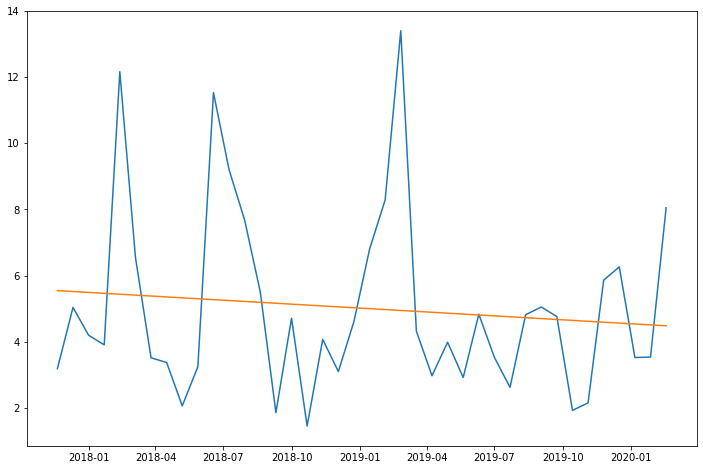

In [64]:
fig = plt.figure(figsize=[12,8])
results_x = [x[0].date() for x in results]
results_y = [x[1] for x in results]
timestamps = [x[0].timestamp() for x in results]
z = np.polyfit(timestamps, results_y, 1)
poly_func = np.poly1d(z)
trend = [poly_func(x) for x in timestamps]
plt.plot(results_x, results_y)
plt.plot(results_x, trend)

In [14]:
type(X_val_daily['la_high'].values[0])

numpy.float64

Simulate a forecast

The article [Analysis of High Temperature Forecast
Accuracy of Consumer Weather Forecasts
from 2005-2016](https://www.forecastwatch.com/wp-content/uploads/High_Temperature_Accuracy_Study_12_Years.pdf) contains a longitudinal study of the accuracy of weather high temperature forecasts.  It tracks the improvements in 3, 5 and 9 day temperature forecasts from 2005 to 2016. The study concluded that:
- The RMS Error for 1 Day High Temperature Forecasts is < 3 def F
- The RMS Error for 5 Day High Temperature Forecasts is 5 deg F
- The RMS Error for 9 Day High Temperature Forecasts is 6 deg F

The data used for training is acutal temperature data.  In order to simulate forecasted temperatures I will add a random component to the actual temperature in a normal distribution around the actual temperature.

In [15]:

temp_rmse = 5.0
X_val_daily['la_high_actual'] = X_val_daily['la_high']
X_val_daily['sd_high_actual'] = X_val_daily['sd_high']
X_val_daily['f_high_actual'] = X_val_daily['f_high']
X_val_daily['sj_high_actual'] = X_val_daily['sj_high']
X_val_daily['sf_high_actual'] = X_val_daily['sf_high']
X_val_daily['sac_high_actual'] = X_val_daily['sac_high']

temps = X_val_daily.loc[:,'la_high'].values
forecast_temps = [x + np.random.normal(0, temp_rmse) for x in temps]
X_val_daily['la_high'] = forecast_temps

temps = X_val_daily.loc[:,'sd_high'].values
forecast_temps = [x + np.random.normal(0, temp_rmse) for x in temps]
X_val_daily['sd_high'] = forecast_temps

temps = X_val_daily.loc[:,'f_high'].values
forecast_temps = [x + np.random.normal(0, temp_rmse) for x in temps]
X_val_daily['f_fr'] = forecast_temps

temps = X_val_daily.loc[:,'sj_high'].values
forecast_temps = [x + np.random.normal(0, temp_rmse) for x in temps]
X_val_daily['sj_high'] = forecast_temps

temps = X_val_daily.loc[:,'sf_high'].values
forecast_temps = [x + np.random.normal(0, temp_rmse) for x in temps]
X_val_daily['sf_high'] = forecast_temps

temps = X_val_daily.loc[:,'sac_high'].values
forecast_temps = [x + np.random.normal(0, temp_rmse) for x in temps]
X_val_daily['sac_fr'] = forecast_temps

Load the model

In [16]:
m = Prophet(weekly_seasonality=True, yearly_seasonality=True)
m.add_regressor('la_high')
m.add_regressor('sd_high')
m.add_regressor('f_high')
m.add_regressor('sj_high')
m.add_regressor('sf_high')
m.add_regressor('sac_high')
m.add_regressor('CA_pop')
m.fit(X_train_daily)

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [17]:
forecast = m.predict(X_val_daily)

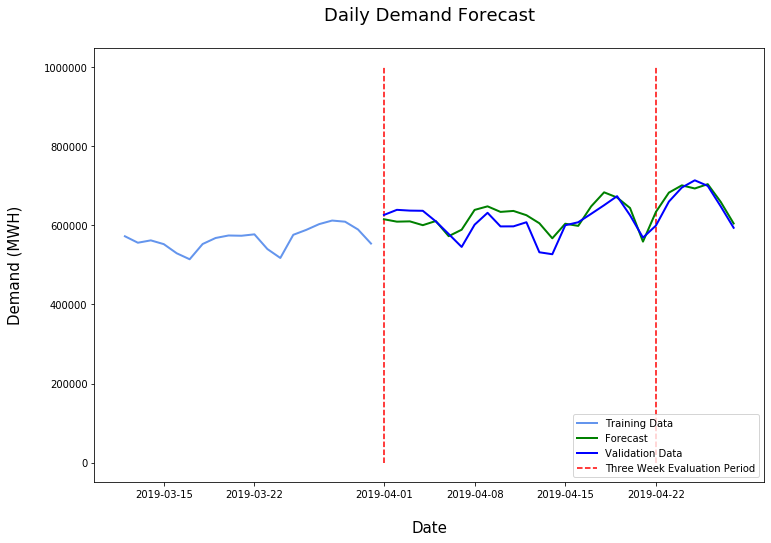

In [36]:
fig = plt.figure(figsize=[12, 8])
fig.patch.set_alpha(0.0)
fig.patch.set_facecolor(None)

ax = fig.add_subplot(1,1,1)
ax.patch.set_visible(False)
ax.set_alpha(0.0)

plt.plot(facecolor=('#000000'), alpha=0.0)


plt.title('Daily Demand Forecast\n', fontsize=18)
plt.xlabel('\nDate', fontsize=15)
plt.ylabel('Demand (MWH)\n', fontsize=15)
plt.legend(loc='lower right')

plt.plot(X_train_daily.index[-20:], X_train_daily['y'].values[-20:], \
    c='cornflowerblue', label='Training Data', linewidth=2)
plt.plot(forecast['ds'].values[:28], forecast['yhat'].values[:28], c='green', label='Forecast', linewidth=2)
plt.plot(X_val_daily.index[:28], X_val_daily['y'].values[:28], c='b', label='Validation Data', linewidth=2)
plt.vlines(X_val_daily.index[0], 0, 1000000, color='r', linestyle = '--', label='Three Week Evaluation Period')
plt.vlines(X_val_daily.index[21], 0, 1000000, color='r', linestyle = '--')


plt.legend( loc='lower right')

plt.savefig('daily_demand_forecast_final.png', Transparent=True)

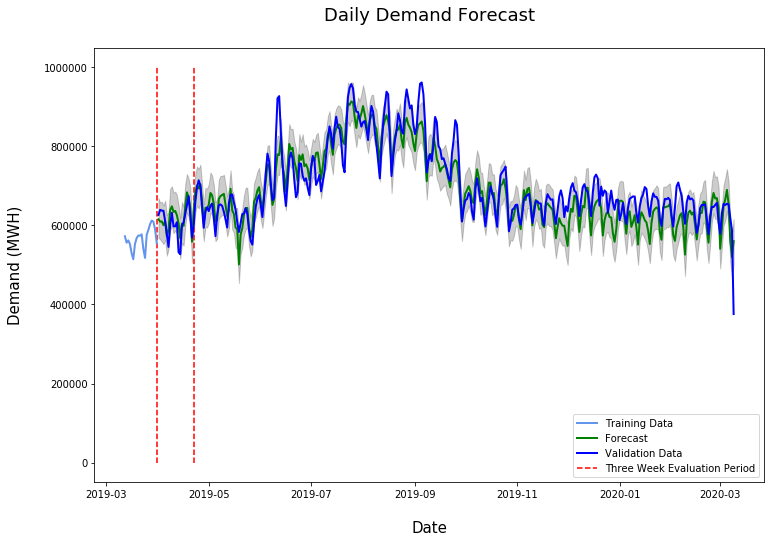

In [42]:
fig = plt.figure(figsize=[12, 8])
fig.patch.set_alpha(0.0)
fig.patch.set_facecolor(None)

ax = fig.add_subplot(1,1,1)
ax.patch.set_visible(False)
ax.set_alpha(0.0)

plt.plot(facecolor=('#000000'), alpha=0.0)


plt.title('Daily Demand Forecast\n', fontsize=18)
plt.xlabel('\nDate', fontsize=15)
plt.ylabel('Demand (MWH)\n', fontsize=15)
plt.legend(loc='lower right')

plt.plot(X_train_daily.index[-20:], X_train_daily['y'].values[-20:], \
    c='cornflowerblue', label='Training Data', linewidth=2)
plt.plot(forecast['ds'].values, forecast['yhat'].values, c='green', label='Forecast', linewidth=2)
plt.plot(X_val_daily.index, X_val_daily['y'].values, c='b', label='Validation Data', linewidth=2)
plt.vlines(X_train_daily.index[-1], 0, 1000000, color='r', linestyle = '--', label='Three Week Evaluation Period')
plt.vlines(X_val_daily.index[21], 0, 1000000, color='r', linestyle = '--')

plt.fill_between(forecast['ds'].values, forecast['yhat_lower'].values, forecast['yhat_upper'].values, color='k', alpha=0.2)


plt.legend( loc='lower right')

plt.savefig('daily_demand_forecast_final_big.png', Transparent=True)

In [21]:
residuals3 = [abs(X_val_daily['y'].values[x] - forecast['yhat'].values[x])/ \
              X_val_daily['y'].values[x] * 100 for x in range(len(forecast['yhat'])-1)]

timestamps = [int(x.timestamp()) for x in X_val_daily.index[:-1]]
z = np.polyfit(timestamps, residuals3, 1)
poly_trend = np.poly1d(z)
trend = [np.mean(residuals3) for x in timestamps]

In [22]:
mape = np.mean(residuals3[:3])
print(mape)

3.56089737728216


In [34]:
len(residuals3)

343

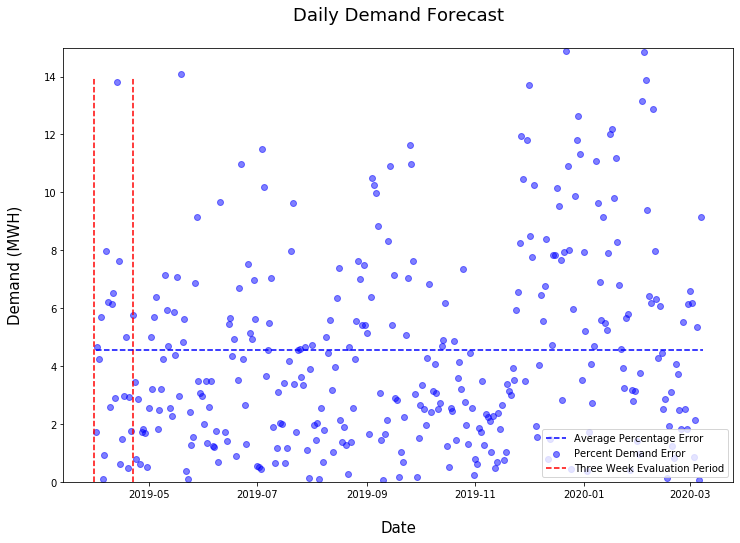

In [35]:
fig = plt.figure(figsize=[12, 8])
fig.patch.set_alpha(0.0)
fig.patch.set_facecolor(None)

ax = fig.add_subplot(1,1,1)
ax.patch.set_visible(False)
ax.set_alpha(0.0)

plt.plot(facecolor=('#000000'), alpha=0.0)


plt.title('Daily Demand Forecast\n', fontsize=18)
plt.xlabel('\nDate', fontsize=15)
plt.ylabel('Demand (MWH)\n', fontsize=15)
plt.legend(loc='lower right')

plt.ylim(0, 15)

plt.scatter(forecast['ds'].values[:342], residuals3[:342], c='b', alpha=0.5, label='Percent Demand Error')
plt.plot(X_val_daily.index[:-1], trend,"b--", label='Average Percentage Error')

plt.vlines(X_train_daily.index[-1], 0, 14, color='r', linestyle = '--', label='Three Week Evaluation Period')
plt.vlines(X_val_daily.index[21], 0, 14, color='r', linestyle = '--')

plt.legend(loc='lower right')


plt.savefig('daily_demand_forecast_error_final_big.png', Transparent=True)

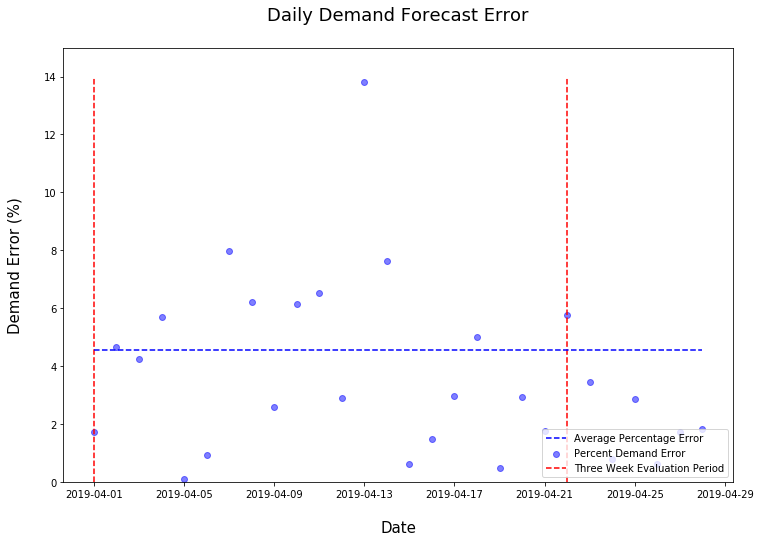

In [38]:
fig = plt.figure(figsize=[12, 8])
fig.patch.set_alpha(0.0)
fig.patch.set_facecolor(None)

ax = fig.add_subplot(1,1,1)
ax.patch.set_visible(False)
ax.set_alpha(0.0)

plt.plot(facecolor=('#000000'), alpha=0.0)


plt.title('Daily Demand Forecast Error\n', fontsize=18)
plt.xlabel('\nDate', fontsize=15)
plt.ylabel('Demand Error (%)\n', fontsize=15)
plt.legend(loc='lower right')

plt.xlim()

plt.scatter(forecast['ds'].values[:28], residuals3[:28], c='b', alpha=0.5, label='Percent Demand Error')
plt.plot(X_val_daily.index[:28], trend[:28],"b--", label='Average Percentage Error')

plt.vlines(X_val_daily.index[0], 0, 14, color='r', linestyle = '--', label='Three Week Evaluation Period')
plt.vlines(X_val_daily.index[21], 0, 14, color='r', linestyle = '--')

plt.legend(loc='lower right')
plt.ylim(0, 15)

plt.savefig('daily_demand_forecast_error_final.png', Transparent=True)

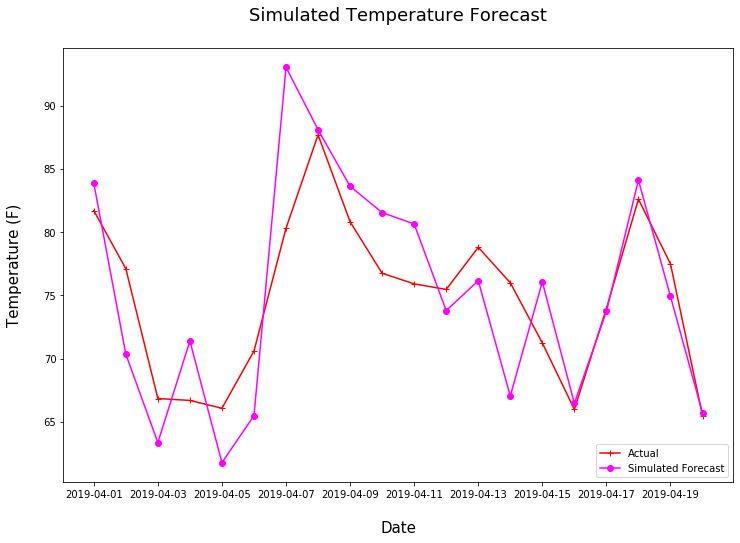

In [41]:
fig = plt.figure(figsize=[12, 8])
fig.patch.set_alpha(0.0)
fig.patch.set_facecolor(None)

ax = fig.add_subplot(1,1,1)
ax.patch.set_visible(False)
ax.set_alpha(0.0)

plt.plot(facecolor=('#000000'), alpha=0.0)


plt.title('Simulated Temperature Forecast\n', fontsize=18)
plt.xlabel('\nDate', fontsize=15)
plt.ylabel('Temperature (F)\n', fontsize=15)
plt.legend(loc='lower right')

plt.plot(X_val_daily.index[:20], X_val_daily['la_high_actual'].values[:20], c='r', marker='+',\
        label='Actual')
plt.plot(X_val_daily.index[:20], X_val_daily['la_high'].values[:20], c='magenta', marker='o', \
        label='Simulated Forecast')
plt.legend(loc='lower right')

plt.savefig('daily_demand_sim_temp_forecast_final.png', Transparent=True)

In [32]:
samples = m.predictive_samples(forecast)

In [33]:
samples

{'yhat': array([[-2.09768603e+07, -2.09596165e+07, -2.09267249e+07, ...,
         -2.08827963e+07, -2.09282849e+07, -2.09391715e+07],
        [-7.70024790e+07, -7.69856631e+07, -7.70834410e+07, ...,
         -7.71272983e+07, -7.70586714e+07, -7.69609554e+07],
        [-1.00640733e+08, -1.00712757e+08, -1.00647662e+08, ...,
         -1.00654882e+08, -1.00664218e+08, -1.00693114e+08],
        ...,
        [-1.30966383e+08, -1.30965498e+08, -1.30992188e+08, ...,
         -1.30959401e+08, -1.31017329e+08, -1.30934158e+08],
        [-1.20333586e+08, -1.20350966e+08, -1.20305553e+08, ...,
         -1.20353027e+08, -1.20319176e+08, -1.20325160e+08],
        [-1.43067205e+08, -1.43030294e+08, -1.43028865e+08, ...,
         -1.43001629e+08, -1.43183210e+08, -1.43057062e+08]]),
 'trend': array([[645493.82042714, 645493.82042714, 645493.82042714, ...,
         645493.82042714, 645493.82042714, 645493.82042714],
        [645336.25653708, 645336.25653708, 645336.25653708, ...,
         645336.25653

In [34]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,CA_pop,CA_pop_lower,CA_pop_upper,additive_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-04-01,645493.820427,576639.647832,674554.266074,645493.820427,645493.820427,53019.592368,53019.592368,53019.592368,-16695.417002,...,-7624.638203,-7624.638203,-7624.638203,-67755.107412,-67755.107412,-67755.107412,0.0,0.0,0.0,628798.403425
1,2019-04-02,645336.256537,558587.662144,657295.541840,645336.256537,645336.256537,53019.592368,53019.592368,53019.592368,-39760.791886,...,19371.953132,19371.953132,19371.953132,-67240.458164,-67240.458164,-67240.458164,0.0,0.0,0.0,605575.464651
2,2019-04-03,645178.692647,558591.889188,658416.085718,645178.692647,645178.692647,53019.592368,53019.592368,53019.592368,-39042.872021,...,20141.301617,20141.301617,20141.301617,-66815.088392,-66815.088392,-66815.088392,0.0,0.0,0.0,606135.820626
3,2019-04-04,645021.128757,572571.489778,669196.530291,645021.128757,645021.128757,53019.592368,53019.592368,53019.592368,-24385.985351,...,22718.561030,22718.561030,22718.561030,-66496.537494,-66496.537494,-66496.537494,0.0,0.0,0.0,620635.143406
4,2019-04-05,644863.564867,553281.822460,651511.247325,644863.564867,644863.564867,53019.592368,53019.592368,53019.592368,-40702.824512,...,18683.938469,18683.938469,18683.938469,-66296.851623,-66296.851623,-66296.851623,0.0,0.0,0.0,604160.740355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,2020-03-05,592079.661696,639169.795345,746611.759583,573421.047503,609925.330045,78439.758085,78439.758085,78439.758085,102610.243288,...,22718.561030,22718.561030,22718.561030,-36118.859093,-36118.859093,-36118.859093,0.0,0.0,0.0,694689.904984
340,2020-03-06,591922.097806,595032.970812,703688.146114,573198.391117,609857.340790,78439.758085,78439.758085,78439.758085,58946.309654,...,18683.938469,18683.938469,18683.938469,-38948.635876,-38948.635876,-38948.635876,0.0,0.0,0.0,650868.407460
341,2020-03-07,591764.533916,525393.396260,632680.989463,573003.919707,609789.351536,78439.758085,78439.758085,78439.758085,-14575.112900,...,-19018.227136,-19018.227136,-19018.227136,-41880.584468,-41880.584468,-41880.584468,0.0,0.0,0.0,577189.421016
342,2020-03-08,591606.970026,456497.043140,561551.949850,572739.422995,609717.114425,78439.758085,78439.758085,78439.758085,-81835.372886,...,-54272.888909,-54272.888909,-54272.888909,-44870.433771,-44870.433771,-44870.433771,0.0,0.0,0.0,509771.597140


In [39]:
X_train_daily.tail()


,y,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,DOW,ds
2019-03-27,603317,1.41733e+07,69.71,66.64,67.03,61.34,65.39,72.08,2,2019-03-27
2019-03-28,612332,1.41733e+07,67.49,66.66,64.57,61.27,61.21,68.11,3,2019-03-28
2019-03-29,609430,1.41733e+07,70.69,66.45,62.49,58.67,61.7,67.93,4,2019-03-29
2019-03-30,589672,1.41733e+07,79.99,69.88,66.95,62.73,67.95,69.09,5,2019-03-30
2019-03-31,554156,1.41733e+07,82.54,79.76,74.24,68.53,72.14,74.41,6,2019-03-31


In [40]:
X_val_daily.head()

,y,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,DOW,ds,la_high_actual,sd_high_actual,f_high_actual,sj_high_actual,sf_high_actual,sac_high_actual,f_fr,sac_fr
2019-04-01,626489,1.41733e+07,83.875962,78.380931,69.323728,71.317328,73.58,77.52,0,2019-04-01,81.71,76.26,77.52,73.87,65.3,73.58,82.641583,78.739702
2019-04-02,639427,1.41733e+07,70.345919,69.694783,69.248338,66.422230,62.96,75.71,1,2019-04-02,77.11,68.42,75.71,64.76,60.96,62.96,77.264614,68.830015
2019-04-03,637476,1.41733e+07,63.355498,59.593722,66.672565,53.364029,62.82,70.45,2,2019-04-03,66.84,64.95,70.45,62.4,57.87,62.82,71.461119,60.005091
2019-04-04,637018,1.41733e+07,71.394067,63.576444,60.136740,66.796452,64.1,69.31,3,2019-04-04,66.69,65.34,69.31,62.68,60.93,64.1,65.177935,56.800423
2019-04-05,610351,1.41733e+07,61.769308,74.231315,67.657846,55.327900,63.16,67.1,4,2019-04-05,66.07,64.94,67.1,64.02,60.99,63.16,71.636515,60.728372
